<a href="https://colab.research.google.com/github/tanuja1708/EEG-emotions/blob/main/seed7%20(Bi_LSTM)%20310.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:
df = pd.read_csv('/content/de_lds_with_labels(310 seed7).csv')


In [15]:
# Separate features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Encode labels and convert to categorical (7 emotions)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=7)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])  # Shape: (samples, 1, 310)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)


In [16]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (55793, 1, 310)
y_train shape: (55793, 7)
X_test shape: (13949, 1, 310)
y_test shape: (13949, 7)


In [17]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)


In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, 310)),  # Expecting input shape (1, 310)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')  # 7 emotions
])


In [19]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the best model weights once stopping is triggered
    mode='max',  # We want to maximize validation accuracy
    verbose=1  # Print a message when stopping occurs
)

# Train model
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=test_dataset,
    callbacks=[early_stopping]  # Include the early stopping callback
)

Epoch 1/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.5513 - loss: 1.1704 - val_accuracy: 0.9528 - val_loss: 0.1465
Epoch 2/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9572 - loss: 0.1307 - val_accuracy: 0.9647 - val_loss: 0.1123
Epoch 3/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9755 - loss: 0.0778 - val_accuracy: 0.9933 - val_loss: 0.0253
Epoch 4/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9854 - loss: 0.0463 - val_accuracy: 0.9834 - val_loss: 0.0520
Epoch 5/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9836 - loss: 0.0528 - val_accuracy: 0.9882 - val_loss: 0.0335
Epoch 6/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9865 - loss: 0.0448 - val_accuracy: 0.9753 - val_loss: 0.0751
Epoch 7/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9802 - loss: 0.0673 - val_accuracy: 0.9913 - val_loss: 0.0284
Epoch 8/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9

In [20]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}")


Test Accuracy: 100.00


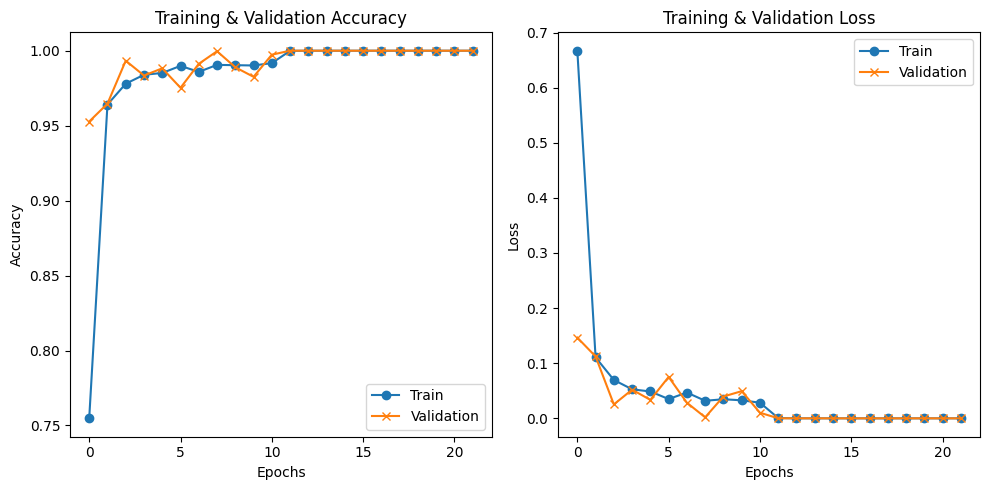

In [21]:
history_dict = history.history
acc, val_acc = history_dict['accuracy'], history_dict['val_accuracy']
loss, val_loss = history_dict['loss'], history_dict['val_loss']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, marker='o')
plt.plot(val_acc, marker='x')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(loss, marker='o')
plt.plot(val_loss, marker='x')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [22]:
# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Classification Report:

              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00      2235
     Disgust       1.00      1.00      1.00      1856
        Fear       1.00      1.00      1.00      2264
       Happy       1.00      1.00      1.00      1604
     Neutral       1.00      1.00      1.00      1322
         Sad       1.00      1.00      1.00      2438
    Surprise       1.00      1.00      1.00      2230

    accuracy                           1.00     13949
   macro avg       1.00      1.00      1.00     13949
weighted avg       1.00      1.00      1.00     13949



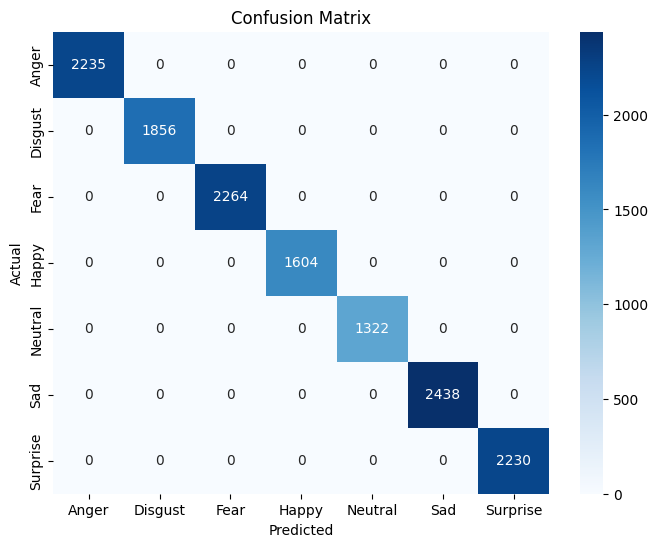

In [23]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [24]:
model.save("eeg_emotion_bilstm_model.h5")
print("Model saved successfully!")


Model saved successfully!


In [25]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 1, 128)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 713,495 (2.72 MB)

 Trainable params: 237,831 (929.03 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 475,664 (1.81 MB)

In [ ]:
loaded_model = tf.keras.models.load_model("eeg_emotion_bilstm_model.h5")


In [ ]:
loaded_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


In [ ]:
loss, acc = loaded_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Test Accuracy: 100.00%


In [ ]:
# Predict on the dataset (or use a specific sample)
predictions = model.predict(X_reshaped)

# Convert logits to predicted class labels
predicted_classes = np.argmax(predictions, axis=1)

# For demonstration, print the first 10 predictions and their corresponding true labels
true_classes = np.argmax(y_categorical, axis=1)

print("Predicted classes: ", predicted_classes[:10])  # First 10 predictions
print("True classes:     ", true_classes[:10])      # First 10 actual classes


2180/2180 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step
Predicted classes:  [3 3 3 3 3 3 3 3 3 3]
True classes:      [3 3 3 3 3 3 3 3 3 3]


In [ ]:
import random

# Select a random row from the dataset (X_test or the whole dataset)
random_idx = random.randint(0, len(X_test) - 1)
random_row = X_test[random_idx].reshape(1, 62, 5)  # Reshape to match model input shape

# Make a prediction
pred_probs = model.predict(random_row)
pred_class = np.argmax(pred_probs, axis=1)

# Decode the predicted class to emotion label
predicted_emotion = le.classes_[pred_class][0]

# Print the results
print(f"Random Row Index: {random_idx}")
print(f"Predicted Emotion: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Random Row Index: 2480
Predicted Emotion: Surprise


In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=test_dataset
)

Epoch 1/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.9882 - loss: 0.0420 - val_accuracy: 0.9951 - val_loss: 0.0152
Epoch 2/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.9987 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 1.9137e-04
Epoch 3/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 1.0000 - loss: 1.4219e-04 - val_accuracy: 1.0000 - val_loss: 8.5238e-05
Epoch 4/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 1.0000 - loss: 6.6058e-05 - val_accuracy: 1.0000 - val_loss: 4.0948e-05
Epoch 5/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 1.0000 - loss: 3.1896e-05 - val_accuracy: 1.0000 - val_loss: 1.9213e-05
Epoch 6/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 1.0000 - loss: 1.4968e-05 - val_accuracy: 1.0000 - val_loss: 8.7354e-06
Epoch 7/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 1.0000 - loss: 6.7771e-06 - val_accuracy: 1.0000 - val_loss: 3.8310e-06
Epoch 8/100
1744/1744 ━━━

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}")


Test Accuracy: 99.92


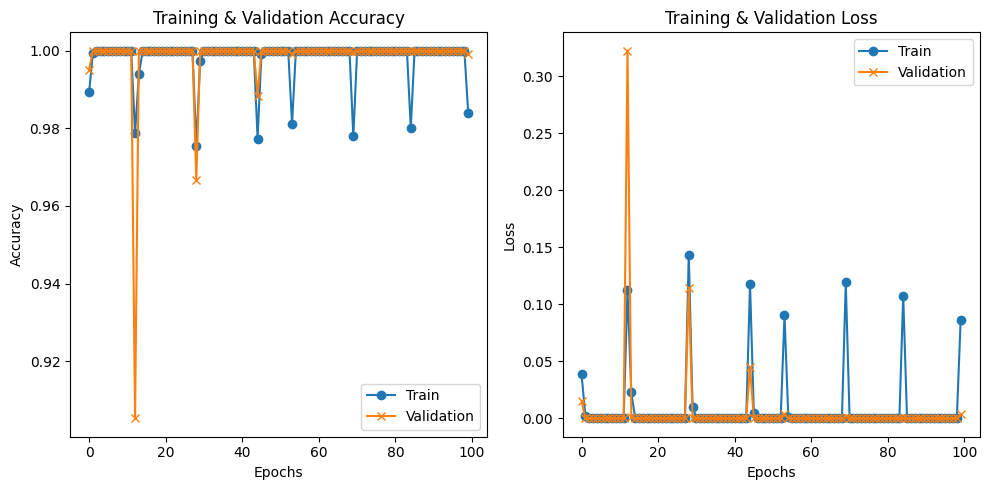

In [ ]:
history_dict = history.history
acc, val_acc = history_dict['accuracy'], history_dict['val_accuracy']
loss, val_loss = history_dict['loss'], history_dict['val_loss']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, marker='o')
plt.plot(val_acc, marker='x')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(loss, marker='o')
plt.plot(val_loss, marker='x')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [ ]:
# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


436/436 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Classification Report:

              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00      2235
     Disgust       1.00      1.00      1.00      1856
        Fear       1.00      1.00      1.00      2264
       Happy       1.00      1.00      1.00      1604
     Neutral       1.00      1.00      1.00      1322
         Sad       1.00      1.00      1.00      2438
    Surprise       1.00      1.00      1.00      2230

    accuracy                           1.00     13949
   macro avg       1.00      1.00      1.00     13949
weighted avg       1.00      1.00      1.00     13949



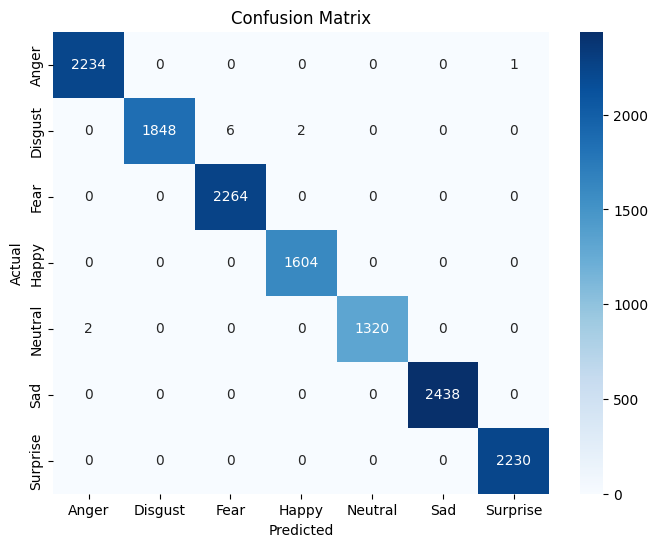

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save("eeg_emotion_bilstm_model(100e).h5")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 62, 128)        │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,015 (957.09 KB)

 Trainable params: 81,671 (319.03 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 163,344 (638.07 KB)

In [ ]:
import pickle # Import the pickle module

with open('eeg_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler saved successfully as eeg_scaler.pkl")

Scaler saved successfully as eeg_scaler.pkl


In [ ]:
with open('eeg_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("LabelEncoder saved successfully as eeg_label_encoder.pkl")


LabelEncoder saved successfully as eeg_label_encoder.pkl


In [ ]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 12.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import welch
from pykalman import KalmanFilter
from tensorflow.keras.models import load_model
import joblib  # ✅ Use joblib instead of pickle

# EEG Channel List (Updated Order)
channels = [
    "FP1", "FPZ", "FP2", "AF3", "AF4", "F7", "F5", "F3", "F1", "FZ", "F2", "F4", "F6", "F8",
    "FT7", "FC5", "FC3", "FC1", "FCZ", "FC2", "FC4", "FC6", "FT8",
    "T7", "C5", "C3", "C1", "CZ", "C2", "C4", "C6", "T8",
    "TP7", "CP5", "CP3", "CP1", "CPZ", "CP2", "CP4", "CP6", "TP8",
    "P7", "P5", "P3", "P1", "PZ", "P2", "P4", "P6", "P8",
    "PO7", "PO5", "PO3", "POZ", "PO4", "PO6", "PO8",
    "CB1", "O1", "OZ", "O2", "CB2"
]

sampling_rate = 200
window_size = 1
segment_length = sampling_rate * window_size

freq_bands = {
    "Delta": (1, 3),
    "Theta": (4, 7),
    "Alpha": (8, 13),
    "Beta": (14, 30),
    "Gamma": (31, 50)
}

kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    transition_covariance=0.2 * np.eye(1),
    observation_covariance=0.5 * np.eye(1),
    initial_state_mean=[20],
    initial_state_covariance=5 * np.eye(1)
)

# def generate_extreme_positive_eeg():
#     t = np.linspace(0, 1, 200)
#     eeg_data = []
#     for _ in range(62):
#         alpha_wave = 30 * np.sin(2 * np.pi * 10 * t)
#         beta_wave = 25 * np.sin(2 * np.pi * 20 * t)
#         gamma_wave = 15 * np.sin(2 * np.pi * 40 * t)
#         eeg_channel_signal = alpha_wave + beta_wave + gamma_wave
#         eeg_data.append(eeg_channel_signal)
#     return np.array(eeg_data)
def generate_balanced_eeg():
    t = np.linspace(0, 1, 200)
    eeg_data = []

    for _ in range(62):  # 62 EEG channels
        # Mix of different frequency components for each channel
        alpha_wave = 15 * np.sin(2 * np.pi * 10 * t)  # Alpha (moderate amplitude)
        beta_wave = 20 * np.sin(2 * np.pi * 20 * t)   # Beta (moderate amplitude)
        theta_wave = 10 * np.sin(2 * np.pi * 5 * t)    # Theta (lower frequency)
        gamma_wave = 12 * np.sin(2 * np.pi * 40 * t)   # Gamma (higher frequency)

        eeg_channel_signal = alpha_wave + beta_wave + theta_wave + gamma_wave
        eeg_data.append(eeg_channel_signal)

    return np.array(eeg_data)



def extract_de_lds():
    eeg_data = generate_balanced_eeg()
    de_features = []
    for channel_data in eeg_data:
        freqs, psd = welch(channel_data, fs=sampling_rate, nperseg=min(200, segment_length), scaling='density')
        band_de = []
        for band, (low, high) in freq_bands.items():
            band_power = psd[(freqs >= low) & (freqs <= high)]
            band_de_value = 0.5 * np.log10(2 * np.pi * np.e * (np.mean(band_power) + 1e-6))
            band_de.append(band_de_value)
        band_de = np.array(band_de).reshape(-1, 1)
        smoothed_de, _ = kf.filter(band_de)
        de_features.append(smoothed_de.flatten())
    de_features = np.array(de_features)
    de_min, de_max = np.min(de_features), np.max(de_features)
    seed_min, seed_max = 15, 27
    de_lds_values = seed_min + (de_features - de_min) / (de_max - de_min) * (seed_max - seed_min)
    print(f"🟢 Extracted DE_LDS Features - Shape: {de_lds_values.shape}")
    return de_lds_values.flatten()

def predict_emotion():
    sample = extract_de_lds().reshape((1, 1, 310))

    # ✅ Load model
    han_model = load_model("/content/eeg_emotion_bilstm_model(100e).h5")

    # ✅ Load y_encoder using joblib
    y_encoder = joblib.load("/content/eeg_label_encoder.pkl")

    prediction = han_model.predict(sample)
    predicted_label = np.argmax(prediction, axis=1)
    decoded_label = y_encoder.inverse_transform(predicted_label)

    print(f"🔵 Predicted Emotion: {decoded_label[0]}")
    return decoded_label[0]

# Run it
predicted_emotion = predict_emotion()



🟢 Extracted DE_LDS Features - Shape: (62, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
🔵 Predicted Emotion: Anger


In [ ]:
loaded_model = tf.keras.models.load_model("/content/eeg_emotion_bilstm_model(100e).h5")


In [ ]:
loaded_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


In [ ]:
import numpy as np
import random
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load the trained model
loaded_model = tf.keras.models.load_model('/content/eeg_emotion_bilstm_model(100e).h5')

# Load the scaler
with open('eeg_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load the label encoder
with open('eeg_label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Load your dataset again if X_reshaped is not already available
import pandas as pd
df = pd.read_csv('/content/de_lds_with_labels(310 seed7).csv')

# Preprocess features
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Encode labels and scale features
y_encoded = le.transform(y)  # Use the already-fitted label encoder
y_categorical = tf.keras.utils.to_categorical(y_encoded, num_classes=7)
X_scaled = scaler.transform(X)
X_reshaped = X_scaled.reshape(-1, 62, 5)

# Split again with tracking of indices to map predictions back to dataset
original_indices = np.arange(len(X_reshaped))
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_reshaped, y_categorical, original_indices, test_size=0.2, random_state=42
) # Unpack into 6 values

# Pick a random test sample
random_idx = random.randint(0, len(X_test) - 1)
random_row = X_test[random_idx].reshape(1, 62, 5)  # Reshape for model input

# Predict
pred_probs = loaded_model.predict(random_row)
pred_class = np.argmax(pred_probs, axis=1)

# Get true class and decode both
true_class = np.argmax(y_test[random_idx])
predicted_emotion = le.inverse_transform([pred_class[0]])[0]
true_emotion = le.inverse_transform([true_class])[0]

# Show results
print(f"✅ Original row in dataset: {test_indices[random_idx]}")
print(f"✅ Random Row Index in test set: {random_idx}")
print(f"🎯 True Emotion: {true_emotion}")
print(f"🤖 Predicted Emotion: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
✅ Original row in dataset: 57618
✅ Random Row Index in test set: 11559
🎯 True Emotion: Sad
🤖 Predicted Emotion: Sad


In [ ]:
import numpy as np
from scipy.signal import welch
from pykalman import KalmanFilter
from keras.models import load_model
import joblib

# Frequency bands for EEG
freq_bands = {
    "Delta": (1, 3),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 31),
    'gamma': (31, 45)
}

# Kalman filter for smoothing
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# Generate synthetic EEG for each emotion
def generate_emotion_eeg(emotion):
    t = np.linspace(0, 1, 200)
    eeg_data = []
    for _ in range(62):
        if emotion == "happy":
            alpha = 20 * np.sin(2 * np.pi * 10 * t)
            beta = 15 * np.sin(2 * np.pi * 20 * t)
            gamma = 5 * np.sin(2 * np.pi * 40 * t)
            signal = alpha + beta + gamma

        elif emotion == "sad":
            theta = 20 * np.sin(2 * np.pi * 5 * t)
            alpha = 5 * np.sin(2 * np.pi * 10 * t)
            signal = theta + alpha

        elif emotion == "angry":
            beta = 25 * np.sin(2 * np.pi * 20 * t)
            gamma = 25 * np.sin(2 * np.pi * 40 * t)
            signal = beta + gamma

        elif emotion == "fear":
            theta = 20 * np.sin(2 * np.pi * 5 * t)
            gamma = 20 * np.sin(2 * np.pi * 40 * t)
            signal = theta + gamma

        elif emotion == "disgust":
            alpha = 5 * np.sin(2 * np.pi * 10 * t)
            beta = 25 * np.sin(2 * np.pi * 20 * t)
            signal = alpha + beta

        elif emotion == "surprise":
            beta = 20 * np.sin(2 * np.pi * 20 * t)
            gamma = 30 * np.sin(2 * np.pi * 40 * t)
            signal = beta + gamma

        elif emotion == "neutral":
            theta = 10 * np.sin(2 * np.pi * 5 * t)
            alpha = 10 * np.sin(2 * np.pi * 10 * t)
            beta = 10 * np.sin(2 * np.pi * 20 * t)
            gamma = 10 * np.sin(2 * np.pi * 40 * t)
            signal = theta + alpha + beta + gamma

        eeg_data.append(signal)
    return np.array(eeg_data)

# Extract DE-LDS features
def extract_de_lds(eeg_data):
    de_features = []
    for channel_data in eeg_data:
        freqs, psd = welch(channel_data, fs=200, nperseg=200, scaling='density')
        band_de = []
        for band, (low, high) in freq_bands.items():
            band_power = psd[(freqs >= low) & (freqs <= high)]
            band_de_value = 0.5 * np.log10(2 * np.pi * np.e * (np.mean(band_power) + 1e-6))
            band_de.append(band_de_value)
        band_de = np.array(band_de).reshape(-1, 1)
        smoothed_de, _ = kf.filter(band_de)
        de_features.append(smoothed_de.flatten())
    de_features = np.array(de_features)
    de_min, de_max = np.min(de_features), np.max(de_features)
    seed_min, seed_max = 15, 27
    de_lds_values = seed_min + (de_features - de_min) / (de_max - de_min) * (seed_max - seed_min)
    return de_lds_values.flatten()

# Predict emotion using model
def predict_emotion(eeg_data, expected_emotion):
    sample = extract_de_lds(eeg_data).reshape((1, 1, 310))
    model = load_model("/content/eeg_emotion_bilstm_model(100e).h5")
    y_encoder = joblib.load("/content/eeg_label_encoder.pkl")
    prediction = model.predict(sample)
    predicted_label = np.argmax(prediction)
    predicted_emotion = y_encoder.inverse_transform([predicted_label])[0]
    print(f"🧠 Expected: {expected_emotion:9s} | 🔮 Predicted: {predicted_emotion:9s} {'✅' if predicted_emotion == expected_emotion else '❌'}")
    return predicted_emotion

# Test all emotions
all_emotions = ["happy", "sad", "angry", "fear", "disgust", "surprise", "neutral"]
for emotion in all_emotions:
    eeg = generate_emotion_eeg(emotion)
    predict_emotion(eeg, emotion)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
🧠 Expected: happy     | 🔮 Predicted: Disgust   ❌


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
🧠 Expected: sad       | 🔮 Predicted: Happy     ❌


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
🧠 Expected: angry     | 🔮 Predicted: Happy     ❌


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
🧠 Expected: fear      | 🔮 Predicted: Anger     ❌


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
🧠 Expected: disgust   | 🔮 Predicted: Surprise  ❌


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
🧠 Expected: surprise  | 🔮 Predicted: Surprise  ❌


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
🧠 Expected: neutral   | 🔮 Predicted: Anger     ❌
